In [ ]:
import cv2
import numpy as np
import scipy.signal

### Side quest: I have a yolo model that detects a scanned image for headers and paragraph. Then, I will use sort_layout_boxes() to sort the headers and 
### paragraph in reading order, before using segment_lines on the headers and paragraph to get individual lines. OpenOCR recognition will be performed on the 
### individual lines

def sort_layout_boxes(res, w):
    """
    Sort text boxes in order from top to bottom, left to right
    Args:
        res: List of dictionaries containing layout information.
        w: Width of image.

    Returns:
        List of dictionaries containing sorted layout information.
    """
    num_boxes = len(res)
    if num_boxes == 1:
        return res

    # Sort on the y axis first or sort it on the x axis
    sorted_boxes = sorted(res, key=lambda x: (x["block_bbox"][1], x["block_bbox"][0]))
    _boxes = list(sorted_boxes)

    new_res = []
    res_left = []
    res_right = []
    i = 0

    while True:
        if i >= num_boxes:
            break
        # Check that the bbox is on the left
        elif (
            _boxes[i]["block_bbox"][0] < w / 4
            and _boxes[i]["block_bbox"][2] < 3 * w / 5
        ):
            res_left.append(_boxes[i])
            i += 1
        elif _boxes[i]["block_bbox"][0] > 2 * w / 5:
            res_right.append(_boxes[i])
            i += 1
        else:
            new_res += res_left
            new_res += res_right
            new_res.append(_boxes[i])
            res_left = []
            res_right = []
            i += 1

    res_left = sorted(res_left, key=lambda x: (x["block_bbox"][1]))
    res_right = sorted(res_right, key=lambda x: (x["block_bbox"][1]))

    if res_left:
        new_res += res_left
    if res_right:
        new_res += res_right

    return new_res


def segment_lines(gray):
    # Invert so text is bright
    inv = 255 - gray

    # Sum pixel intensities row-wise (horizontal projection)
    row_sum = inv.sum(axis=1)

    # Smooth for stability
    smoothed = np.convolve(row_sum, np.ones(5), mode='same')

    # --- Step 1: Compute threshold via 2 peaks ---
    hist_counts, hist_bins = np.histogram(smoothed, bins=30)
    peaks, _ = scipy.signal.find_peaks(hist_counts, distance=10)
    
    if len(peaks) < 2:
        return [gray]

    # Take the 2 largest peaks
    top_peaks = sorted([(hist_counts[p], hist_bins[p]) for p in peaks], reverse=True)[:2]
    peak_vals = sorted([p[1] for p in top_peaks])

    # Midpoint between the two peaks = threshold
    threshold = (peak_vals[0] + peak_vals[1]) / 2

    # --- Step 2: Detect one-on/one-off transition blocks over 5+ lines ---
    binary_above = smoothed > threshold
    segments = []
    in_block = False
    start = 0
    # print(binary_above)
    for i in range(len(binary_above)):
        if binary_above[i] and not in_block:
            if np.sum(binary_above[i:i+6]) >= 6:
                start = i
                in_block = True
        elif not binary_above[i] and in_block:
            if np.sum(binary_above[i:i+5]) <= 0:
                end = i
                segments.append((start, end))
                in_block = False
    if in_block:
        segments.append((start, len(binary_above)))

    # --- Step 3: Compute midpoints and extrapolate spacing ---
    midpoints = [(s + e) // 2 for s, e in segments]
    if len(midpoints) < 2:
        return [gray]

    spacing = int(np.median(np.diff(midpoints)))

    # --- Step 4: Extrapolate line positions ---
    first_mid = midpoints[0]
    last_mid = midpoints[-1]
    height = gray.shape[0]

    line_mids = []
    mid = first_mid
    while mid > 0:
        mid -= spacing
        if mid > 0:
            line_mids.insert(0, mid)

    line_mids += midpoints

    mid = last_mid
    while mid + spacing < height:
        mid += spacing
        line_mids.append(mid)

    # --- Step 5: Crop based on midpoints ---
    height, width = gray.shape[:2]
    pad = spacing // 2
    line_imgs = []
    for mid in line_mids:
        top = max(mid - pad, 0)
        bottom = min(mid + pad, height)
        crop = gray[top:bottom, 0:width]
        line_imgs.append(crop)

    return line_imgs

In [ ]:
### Side quest: Here is how I train my yolo model. Look at ./dataset_yolo for how your dataset should be formatted

from ultralytics import YOLO
import os
import sys

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
sys.modules['albumentations'] = None

model = YOLO("yolo12s.pt")

# Optimized training with effective augmentations
model.train(
    data="./dataset_yolo/data.yaml",
    epochs=200,
    imgsz=960,
    patience=15,
    
    # Enable standard augmentations
    augment=True,
    
    # Optimization settings
    batch=12,     # Adjust based on your GPU memory
    cos_lr=True,  # Cosine LR scheduler for better convergence
    
    # Save settings
    save_period=10,  # Save checkpoints every 10 epochs
    project="results_yolo",  # Project folder
    name="yolov12s_defaultaug_960_block(betterdata)",  # Experiment name
)

Visualizing sample_1896.jpg with labels from sample_1896.txt
3544 2481
./dataset_yolo/labels/train/sample_1896.txt


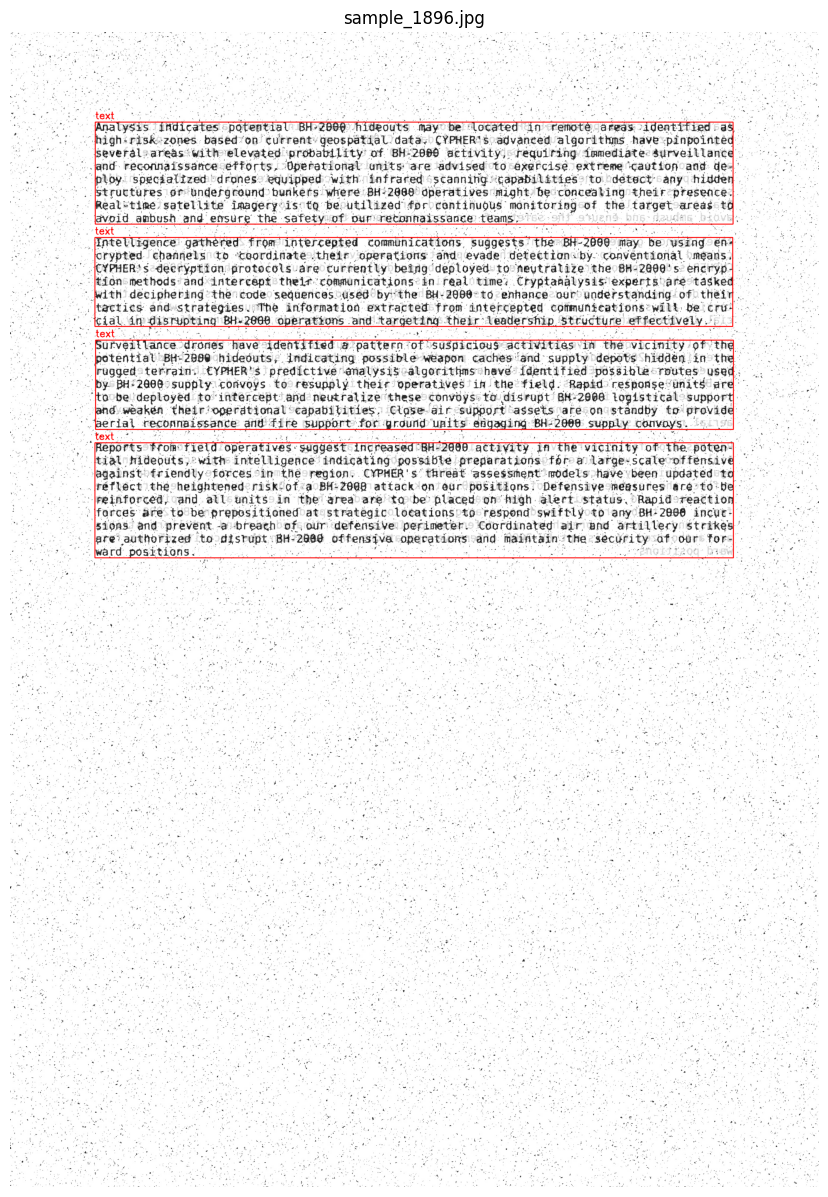

Visualizing sample_1894.jpg with labels from sample_1894.txt
3544 2481
./dataset_yolo/labels/train/sample_1894.txt


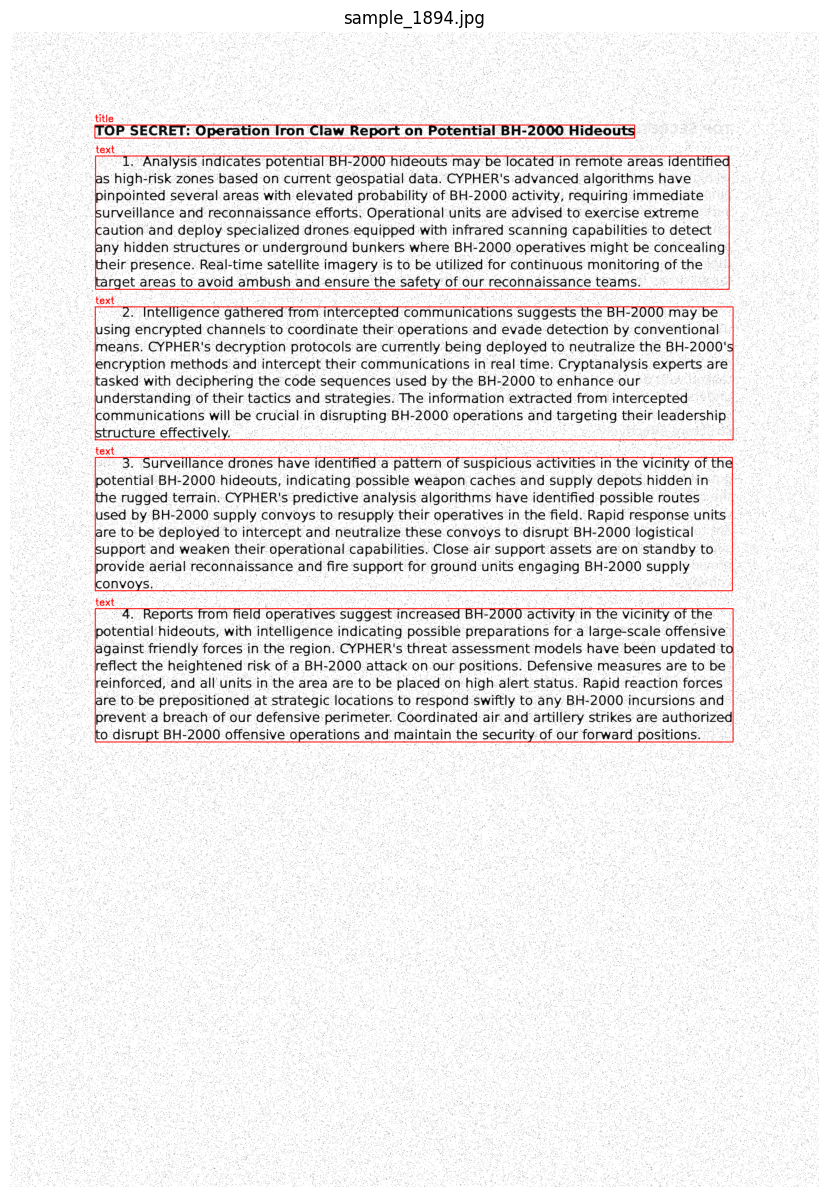

Visualizing sample_189.jpg with labels from sample_189.txt
3544 2481
./dataset_yolo/labels/train/sample_189.txt


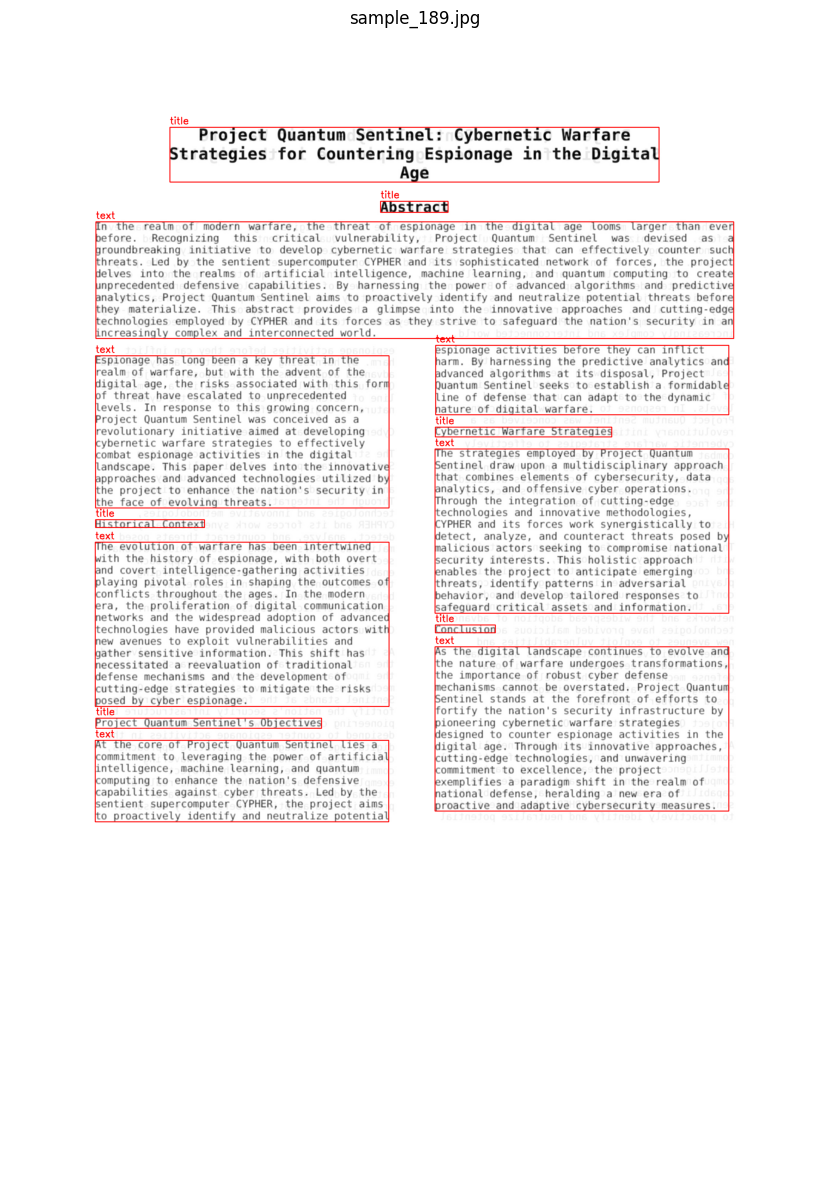

In [4]:
# Here is how my dataset looks like

import random
import os
import cv2
import matplotlib.pyplot as plt

# Paths
train_images_dir = './dataset_yolo/images/train'
train_labels_dir = './dataset_yolo/labels/train'

# # Label map
label_map = {
    0: "title",
    1: "text"
}

# Get image list
image_files = [f for f in os.listdir(train_images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
random.shuffle(image_files)
selected_images = image_files[:3]

# Plotting
for image_file in selected_images:
    image_path = os.path.join(train_images_dir, image_file)
    label_file = os.path.splitext(image_file)[0] + '.txt'
    label_path = os.path.join(train_labels_dir, label_file)

    print(f"Visualizing {image_file} with labels from {label_file}")
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    h, w, _ = image.shape
    print(h, w)

    # Draw YOLO boxes
    print(label_path)
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                cls_id = int(parts[0])
                cx, cy, bw, bh = map(float, parts[1:])
                x1 = int((cx - bw / 2) * w)
                y1 = int((cy - bh / 2) * h)
                x2 = int((cx + bw / 2) * w)
                y2 = int((cy + bh / 2) * h)

                cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
                label = label_map.get(cls_id, str(cls_id))
                cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 2)

    # Display full-size image
    plt.figure(figsize=(20, 15))
    plt.imshow(image)
    plt.axis('off')
    plt.title(image_file)
    plt.show()
